In [1]:
import sys
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
from torch.distributions.categorical import Categorical

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
class BasicParameters(nn.Module):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        
    @property
    def shape(self):
        return self().shape

    def forward(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def rebatch(self, input):
        return input


In [20]:
class StraightThroughParameters(nn.Module):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1,
                 n_samples=1,
                 temperature=1.,
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.n_samples = n_samples
        self.temperature = temperature
        
        self.softmax    = nn.Softmax(dim=-1)
        self.num_classes= self.theta.shape[1]
        self.n_dims     = len(self.theta.shape)
        self.batch_size = self.theta.shape[0]
        
        self.perm_order   = [0] + list(range(2,self.n_dims)) + [1]
        self.reverse_perm = [0,self.n_dims-1] + list(range(1,self.n_dims-1))
                
    @property
    def shape(self):
        return get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_probs_and_dist(self):
        logits = self.get_logits()
        logits = logits.permute( *self.perm_order ) \
                   .div(self.temperature)
        probs  = self.softmax(logits)
        dist   = Categorical(probs=probs)
        return probs, dist
    
    def sample(self):
        probs, dist = self.get_probs_and_dist()
        sample = dist.sample((self.n_samples,))
        sample = F.one_hot(sample, self.num_classes)
        sample = sample - probs.detach() + probs
        sample = sample.flatten(0,1)
        sample = sample.permute( *self.reverse_perm )
        return sample
    
    def forward(self):
        return self.sample()
    
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)

In [38]:
my_params = StraightThroughParameters(
    nn.Parameter(torch.randn([4,2,3])), 
    left_flank=None, 
    right_flank=None,
    n_samples=50
)


In [39]:
F.softmax( my_params.get_logits(), 1 )

tensor([[[0.3589, 0.5996, 0.1441],
         [0.6411, 0.4004, 0.8559]],

        [[0.3283, 0.3885, 0.6693],
         [0.6717, 0.6115, 0.3307]],

        [[0.3904, 0.2190, 0.4967],
         [0.6096, 0.7810, 0.5033]],

        [[0.4073, 0.5090, 0.9008],
         [0.5927, 0.4910, 0.0992]]], grad_fn=<SoftmaxBackward>)

In [40]:
my_params.reverse_perm

[0, 2, 1]

In [41]:
my_params.rebatch( my_params() )

tensor([[[0.3600, 0.5800, 0.0800],
         [0.6400, 0.4200, 0.9200]],

        [[0.3200, 0.4800, 0.5600],
         [0.6800, 0.5200, 0.4400]],

        [[0.4600, 0.2200, 0.5400],
         [0.5400, 0.7800, 0.4600]],

        [[0.3800, 0.5400, 0.9400],
         [0.6200, 0.4600, 0.0600]]], grad_fn=<MeanBackward1>)

In [ ]:
class NUTS_parameters(nn.Module):
    def __init__(self,
                 theta_0=None,
                 num_sequences=1,
                 num_st_samples=1,
                 seq_len=200, 
                 padding_len=400,
                 vocab_len=4,
                 temperature=1,
                 ST_sampling=True,
                 **kwargs):
        super(NUTS_parameters, self).__init__()
        self.theta_0 = theta_0
        self.num_sequences = num_sequences
        self.num_st_samples = num_st_samples
        self.seq_len = seq_len  
        self.padding_len = padding_len
        self.vocab_len = vocab_len
        self.temperature = temperature
        self.ST_sampling = ST_sampling
        
        self.softmax = nn.Softmax(dim=1)
        self.grad = torch.autograd.grad
        
        # register initial theta. if it was not given, initialize randomly
        self.initialize_theta(one_hot=True)
        
        # initialize the momentum r
        self.register_buffer('r', torch.randn_like(self.theta))
        
        # create and register the padding tensors
        upPad_logits, downPad_logits = utils.create_paddingTensors(self.num_sequences, self.padding_len,
                                                                   self.num_st_samples, self.ST_sampling)
        self.register_buffer('upPad_logits', upPad_logits)
        self.register_buffer('downPad_logits', downPad_logits)
                
    def forward(self, theta):
        softmaxed_theta = self.softmax(theta / self.temperature)
        if self.ST_sampling:
           softmaxed_theta = self.softmax(theta / self.temperature)
           probs = Categorical(torch.transpose(softmaxed_theta, 1, 2))
           idxs = probs.sample((self.num_st_samples, ))
           sampled_theta_T = F.one_hot(idxs, num_classes=self.vocab_len)   
           sampled_theta = torch.transpose(sampled_theta_T, 2, 3)
           sampled_theta = sampled_theta - softmaxed_theta.detach() + softmaxed_theta
           sampled_theta = self.pad(sampled_theta)
           sampled_theta = sampled_theta.view(self.num_st_samples * self.num_sequences, self.vocab_len, -1)
           return sampled_theta
        else:
            return self.pad(softmaxed_theta)
         
    def initialize_theta(self, one_hot=True):
        if self.theta_0 is not None:
            self.register_buffer('theta', self.theta_0)
        else:
            size = (self.num_sequences, self.vocab_len, self.seq_len)
            if one_hot:
                theta = np.zeros(size)
                for seqIdx in range(self.num_sequences):
                    for step in range(self.seq_len):
                        random_token = np.random.randint(self.vocab_len)
                        theta[seqIdx, random_token, step] = 1      
                self.register_buffer('theta', torch.tensor(theta, dtype=torch.float))
            else:
                self.register_buffer('theta', self.softmax(torch.rand(size)))
           
    def pad(self, tensor, multi_sampling_off=False):
        if self.padding_len > 0:
            if multi_sampling_off:
                size = tensor.shape
                upPad_logits, downPad_logits = self.upPad_logits[0].view(size), self.downPad_logits[0].view(size)
                return torch.cat([ upPad_logits, tensor, downPad_logits], dim=-1)
            else:
                return torch.cat([ self.upPad_logits, tensor, self.downPad_logits], dim=-1)
        else: 
            return tensor


In [3]:
class NUTS3(nn.Module):
    def __init__(self,
                 params,
                 energy_fn,
                ):
        
        super().__init__()
        self.params = params
        self.energy_fn  = energy_fn
        
        self.d_max = 1000.
        
    def calc_energy(self):
        energy = self.energy_fn(self.params())
        energy = self.params.rebatch( energy )
        return energy

    def leapfrog(self, theta, r, epsilon):
        
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
            theta = theta + r.mul(epsilon)
            
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
        return theta, r, energy
        
    def buildtree(self, theta, r, u, v, j, epsilon):
        #print(f'current j: {j}')
        if j == 0:
            theta_p, r_p, energy_p = self.leapfrog(theta, r, v*epsilon)
            batch_dot = torch.einsum('bs,bs->b', r_p.flatten(1), r_p.flatten(1))
            hamilton  = energy_p + batch_dot.div(2.)
            n_p = (u <= torch.exp(-hamilton)).type(torch.long)
            s_p = (torch.log(u).add(-self.d_max) < -hamilton).type(torch.long)
            #print(f'inner j: {j}')
            #print(f'log u: {u.log()}, -H: {-hamilton}')
            #print(theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p, sep='\n')
            return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
        
        else:
            #print(f'inner j: {j}')
            bt_pack = self.buildtree(theta, r, u, v, j-1, epsilon)
            theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p = bt_pack
            #[print(a) for a in bt_pack]
            if s_p.sum() > 0:
                if v == -1:
                    bt_pack = self.buildtree(theta_r, r_r, u, v, j-1, epsilon)
                    theta_r, r_r, _, _, theta_pp, n_pp, s_pp = bt_pack
                    
                else:
                    bt_pack = self.buildtree(theta_f, r_f, u, v, j-1, epsilon)
                    _, _, theta_f, r_f, theta_pp, n_pp, s_pp = bt_pack
                
                update_flag = torch.rand(n_pp.size(), dtype=torch.float, 
                                         layout=n_pp.layout, device=n_pp.device)
                update_flag = update_flag < n_pp.div( n_p + n_pp )
                update_flag = torch.logical_and(update_flag, s_p.ge(1) )
                theta_p[ update_flag ] = theta_pp[ update_flag ]
                s_p = s_p * s_pp * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                        .ge(0.).type(torch.long) * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                        .ge(0.).type(torch.long)
                n_p = n_p + n_pp
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p)
            return theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p
        
    def init_trajectory(self, theta):
        with torch.no_grad():
            r_0 = torch.randn_like( theta )
            energy_0 = self.calc_energy()
            batch_dot= torch.einsum('bs,bs->b', r_0.flatten(1), r_0.flatten(1))
            hamilton = energy_0 + batch_dot.div(2.)
            u   = torch.rand_like( hamilton ).mul( torch.exp(-hamilton) )
            
            theta_r, theta_f = theta, theta
            r_r, r_f = r_0, r_0
            j = 0
            theta_m = theta
            n = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
            s = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
        return u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s
    
    def sample_trajectory(self, theta, epsilon):
        u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s = self.init_trajectory(theta)
        while s.sum() >= 1:
            v = torch.randn([1], dtype=torch.float, layout=theta.layout, device=theta.device) \
                  .ge(0.).mul(2.).add(-1.)
            if v < 0:
                theta_r, r_r, _, _, theta_p, n_p, s_p = self.buildtree(theta_r, r_r, u, v, j, epsilon)
            else:
                _, _, theta_f, r_f, theta_p, n_p, s_p = self.buildtree(theta_f, r_f, u, v, j, epsilon)
            
            #print('traj results:')
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p, sep='\n')
            update_flag = torch.rand_like(n.type(torch.float))
            update_flag = update_flag <= torch.minimum( n / n_p, torch.ones_like(n.type(torch.float)) )
            update_flag = torch.logical_and( update_flag, s.ge(1) )
            update_flag = torch.logical_and( update_flag, s_p.ge(1) )
            #print(f'update_flag: {update_flag}')
            theta_m[ update_flag ] = theta_p[ update_flag ]
            
            n = n + n_p
            s = s * s_p * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                  .ge(0.).type(torch.long) * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                  .ge(0.).type(torch.long)
            j = j + 1
        
        return theta_m.detach().clone()
    
    def collect_samples(self, epsilon, n_samples=1):
        samples = []
        theta_m = self.params.theta.clone().detach()
        for m in range(n_samples):
            theta_m = self.sample_trajectory( theta_m, epsilon )
            samples.append( theta_m )
        return samples


In [4]:
def my_energy(in_tensor):
    return in_tensor.pow(2).div(2).sum(dim=(1,2))

class my_rosenbrock(nn.Module):
    def __init__(self, a=0, b=5):
        super().__init__()
        self.a = a
        self.b = b
        
    def forward(self, in_tensor):
        x = in_tensor[:,0]
        y = in_tensor[:,1]
        
        x = x.flatten(1).sum(dim=1)
        y = y.flatten(1).sum(dim=1)
        
        return (self.a - x).pow(2) + (y - x.pow(2)).mul(self.b).pow(2)
    
def multimodal(in_tensor):
    return torch.add( in_tensor.add(-2).pow(2).div(2).sum(dim=(1,2)).mul(-1).exp(), 
                      in_tensor.add(2).pow(2).div(2).sum(dim=(1,2)).mul(-1).exp() ) \
             .div(2).log().mul(-1.)

In [5]:
checker = torch.randn(4,2,1)
checker

tensor([[[ 0.8610],
         [-0.4584]],

        [[-0.6955],
         [ 0.5431]],

        [[ 1.3125],
         [-0.9227]],

        [[ 1.0385],
         [ 0.6202]]])

In [6]:
my_energy( checker )

tensor([0.4757, 0.3893, 1.2869, 0.7316])

In [7]:
banana = my_rosenbrock()

banana( checker )

tensor([ 36.7232,   0.5719, 176.6519,   6.3290])

In [8]:
multimodal( checker )

tensor([4.1816, 4.3436, 5.0096, 2.1059])

In [9]:
my_params = BasicParameters(
    nn.Parameter(torch.randn([4,2,1])), 
    left_flank=None, 
    right_flank=None
)

my_sampler = NUTS3( my_params, my_energy )

In [10]:
test_theta = torch.randn([4,2,1])
test_r     = torch.randn([4,2,1])
print(test_theta)
print(test_r)
print(my_sampler.params.theta)

tensor([[[ 0.3955],
         [ 1.2746]],

        [[ 0.6299],
         [ 0.5575]],

        [[ 0.0644],
         [ 0.5191]],

        [[-0.5710],
         [ 1.0758]]])
tensor([[[-0.4327],
         [-0.2193]],

        [[-0.1658],
         [-0.3493]],

        [[ 0.0283],
         [ 0.2860]],

        [[-0.1645],
         [ 0.5661]]])
Parameter containing:
tensor([[[-0.8920],
         [ 0.0272]],

        [[-0.0800],
         [-0.9774]],

        [[-0.5937],
         [ 0.7979]],

        [[-1.0308],
         [-0.7202]]], requires_grad=True)


In [11]:
my_sampler.calc_energy()

tensor([0.3982, 0.4809, 0.4945, 0.7906], grad_fn=<SumBackward1>)

In [12]:
my_sampler.params().pow(2).sum(dim=(1,2))

tensor([0.7964, 0.9618, 0.9891, 1.5812], grad_fn=<SumBackward1>)

In [13]:
torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.)

tensor([0.1177, 0.0748, 0.0413, 0.1738])

In [14]:
( my_sampler.calc_energy() + torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.) ).mul(-1.).exp()

tensor([0.5970, 0.5737, 0.5852, 0.3812], grad_fn=<ExpBackward>)

In [15]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.0243, 0.1259, 0.3874, 0.1608]),
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([[[-0.2279],
          [-2.0820]],
 
         [[-0.1897],
          [-0.4281]],
 
         [[-0.8867],
          [-0.1038]],
 
         [[-0.6868],
          [ 1.2494]]]),
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([[[-0.2279],
          [-2.0820]],
 
         [[-0.1897],
          [-0.4281]],
 
         [[-0.8867],
          [-0.1038]],
 
         [[-0.6868],
          [ 1.2494]]]),
 0,
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([1, 1, 1, 1]),
 tensor([1, 1, 1, 1]))

In [16]:
v = torch.randn([1], dtype=torch.float, layout=test_theta.layout, device=test_theta.device) \
                  .ge(0.).mul(2.).add(-1.)
v

tensor([-1.])

In [17]:
check_theta_r

tensor([[[ 0.3955],
         [ 1.2746]],

        [[ 0.6299],
         [ 0.5575]],

        [[ 0.0644],
         [ 0.5191]],

        [[-0.5710],
         [ 1.0758]]])

In [18]:
my_sampler.buildtree(check_theta_r, check_r_r, init_vals[0], v, 4, 1e-1)

(tensor([[[ 0.2162],
          [ 2.0456]],
 
         [[ 0.1711],
          [ 0.4118]],
 
         [[ 0.8855],
          [ 0.0884]],
 
         [[ 0.7044],
          [-1.2825]]]),
 tensor([[[ 0.4016],
          [ 1.3347]],
 
         [[ 0.6345],
          [ 0.5694]],
 
         [[ 0.0908],
          [ 0.5213]],
 
         [[-0.5495],
          [ 1.0367]]]),
 tensor([[[ 0.4552],
          [ 2.2293]],
 
         [[ 0.6542],
          [ 0.6805]],
 
         [[ 0.6819],
          [ 0.4362]],
 
         [[-0.0828],
          [ 0.1812]]]),
 tensor([[[-0.1873],
          [-1.9445]],
 
         [[-0.1259],
          [-0.3703]],
 
         [[-0.8758],
          [-0.0515]],
 
         [[-0.7403],
          [ 1.3505]]]),
 tensor([[[ 0.4552],
          [ 2.2293]],
 
         [[ 0.6542],
          [ 0.6805]],
 
         [[ 0.6819],
          [ 0.4362]],
 
         [[-0.0828],
          [ 0.1812]]]),
 tensor([16, 16, 16, 16]),
 tensor([0, 0, 1, 1]))

In [19]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.0300, 0.4573, 0.0423, 0.0894]),
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([[[-0.4977],
          [ 0.0590]],
 
         [[ 1.1411],
          [ 0.2392]],
 
         [[ 0.7851],
          [ 2.2103]],
 
         [[ 1.4385],
          [ 0.0158]]]),
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([[[-0.4977],
          [ 0.0590]],
 
         [[ 1.1411],
          [ 0.2392]],
 
         [[ 0.7851],
          [ 2.2103]],
 
         [[ 1.4385],
          [ 0.0158]]]),
 0,
 tensor([[[ 0.3955],
          [ 1.2746]],
 
         [[ 0.6299],
          [ 0.5575]],
 
         [[ 0.0644],
          [ 0.5191]],
 
         [[-0.5710],
          [ 1.0758]]]),
 tensor([1, 1, 1, 1]),
 tensor([1, 1, 1, 1]))

In [20]:
my_sample = my_sampler.sample_trajectory(check_theta_r, 1e-1)

In [21]:
my_sample

tensor([[[ 0.4787],
         [ 1.0477]],

        [[ 1.4239],
         [-0.3086]],

        [[ 0.0761],
         [ 0.3532]],

        [[-1.0731],
         [ 1.4862]]])

In [22]:
my_sampler.params.cuda()

BasicParameters()

In [23]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time()-start)

80.89300322532654


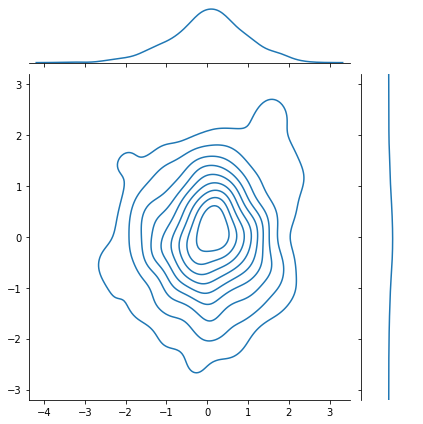

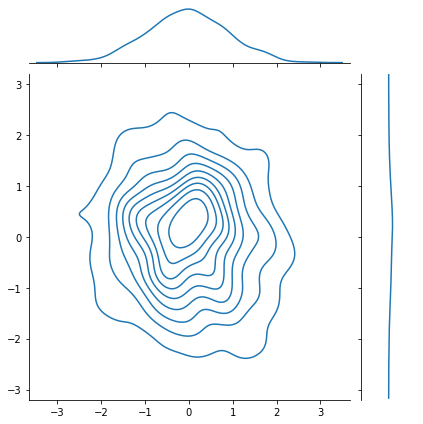

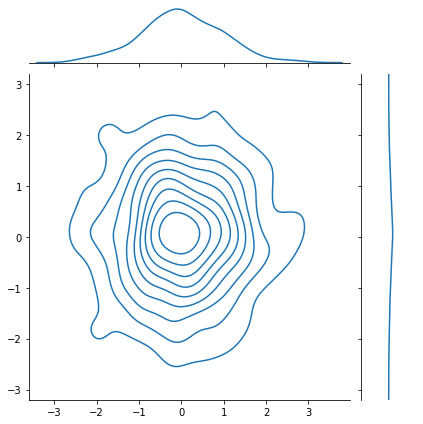

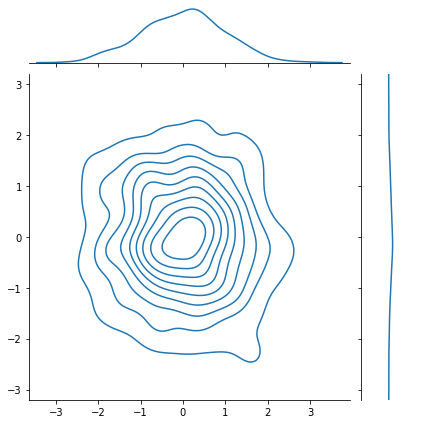

In [24]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1].cpu().numpy(),
                      kind='kde')
    plt.xlim(-3.2, 3.2)
    plt.ylim(-3.2, 3.2)
    plt.show()

In [25]:
my_params.theta.data = torch.randn_like( my_params.theta.data )*0.3

In [26]:
start = time.time()
my_sampler = NUTS3( my_params, banana )
my_samples = my_sampler.collect_samples(1e-2,400)
print(time.time() - start)

230.45986890792847


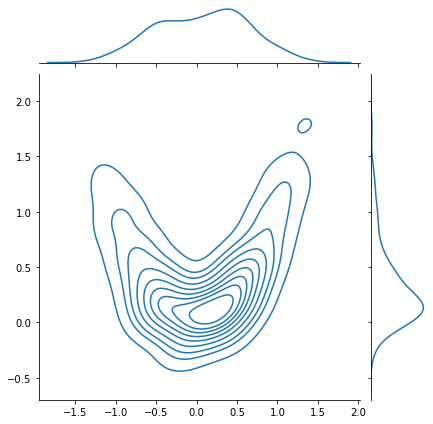

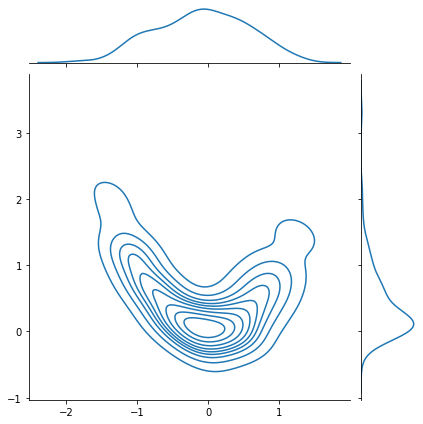

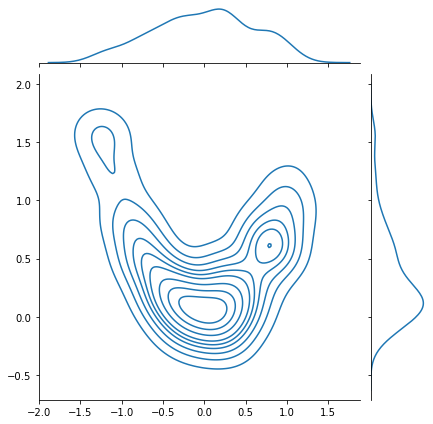

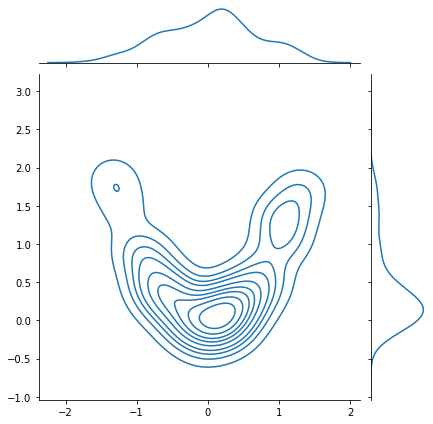

In [27]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1].cpu().numpy(),
                      kind='kde')
    #plt.xlim(-3.2, 3.2)
    #plt.ylim(-3.2, 3.2)
    plt.show()

In [28]:
my_samples[0]

tensor([[[-0.0460],
         [-0.0521]],

        [[ 0.0234],
         [ 0.1557]],

        [[ 0.2147],
         [-0.1136]],

        [[-0.0070],
         [-0.2078]]], device='cuda:0')

In [29]:
my_params.theta.data = torch.randn_like( my_params.theta.data )

In [30]:
my_params.cuda()
start = time.time()
my_sampler = NUTS3( my_params, multimodal )
my_samples = my_sampler.collect_samples(1.,1000)
my_params.cpu()
print(time.time() - start)

26.759159326553345


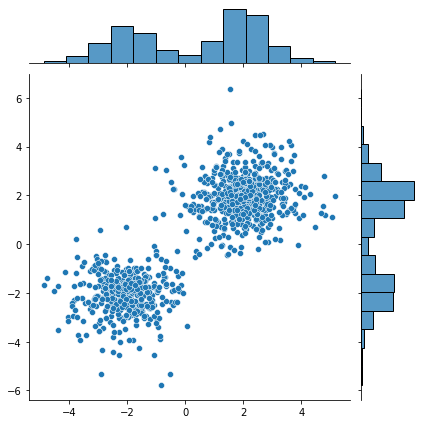

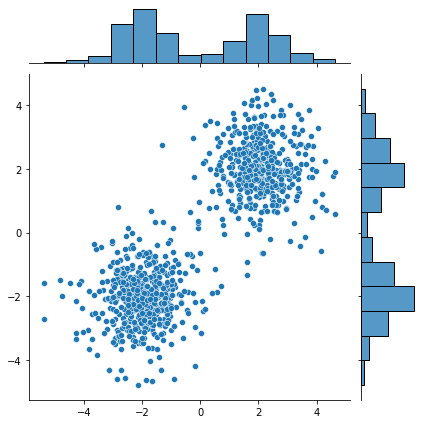

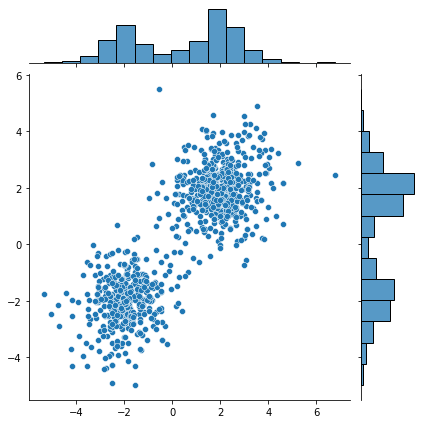

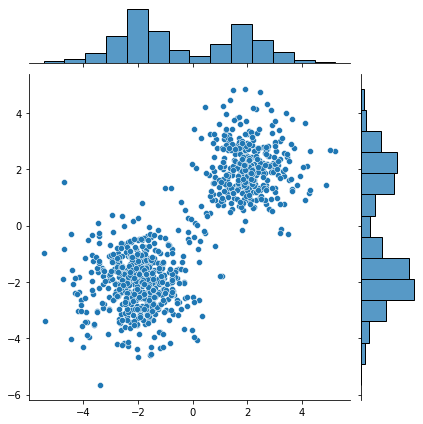

In [31]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0][-1000:].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1][-1000:].cpu().numpy())
    #plt.xlim(-3.2, 3.2)
    #plt.ylim(-3.2, 3.2)
    plt.show()

In [32]:
sobol = torch.quasirandom.SobolEngine(my_params.theta[0].numel(), scramble=True)

In [33]:
hold = sobol.draw(100)

In [34]:
hold

tensor([[0.7258, 0.1271],
        [0.8417, 0.9106],
        [0.1149, 0.3538],
        [0.2374, 0.8600],
        [0.9642, 0.4362],
        [0.5953, 0.6494],
        [0.3221, 0.0848],
        [0.3035, 0.9616],
        [0.5298, 0.2720],
        [0.9105, 0.5477],
        [0.1368, 0.2489],
        [0.0105, 0.7229],
        [0.7842, 0.0411],
        [0.6486, 0.7621],
        [0.4222, 0.4399],
        [0.3811, 0.7847],
        [0.6704, 0.4822],
        [0.7702, 0.6991],
        [0.0595, 0.0057],
        [0.1819, 0.5303],
        [0.8926, 0.2043],
        [0.5399, 0.9916],
        [0.2506, 0.3060],
        [0.3745, 0.6789],
        [0.5857, 0.1183],
        [0.9815, 0.8431],
        [0.1927, 0.3921],
        [0.0664, 0.8864],
        [0.8552, 0.3180],
        [0.7045, 0.5974],
        [0.4933, 0.1699],
        [0.4808, 0.9233],
        [0.6914, 0.3743],
        [0.8739, 0.5870],
        [0.0845, 0.1476],
        [0.2033, 0.6386],
        [0.9927, 0.0662],
        [0.5651, 0.8492],
        [0.3